### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Validation samples: ', len(X_val)) 
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(X_val.head())

Compete set samples: 22184
Validation samples:  1105
Test samples: 14792


image                                          Fish_mask  \
4420  43dda13.jpg                                                NaN   
4421  3624c8b.jpg                                                NaN   
4422  519820d.jpg  293243 664 294643 664 296043 664 297443 664 29...   
4423  9ede0ba.jpg  860577 8 861977 8 863378 3 863382 6 864777 1 8...   
4424  99b9bd5.jpg  1362214 400 1363614 400 1365014 400 1366414 40...   

                                            Flower_mask  \
4420  2163025 1187 2164425 1187 2165825 1187 2167225...   
4421  1209169 427 1210569 427 1211969 427 1213369 42...   
4422                                                NaN   
4423  1366803 985 1368203 985 1369603 985 1371003 98...   
4424                                                NaN   

                                            Gravel_mask  \
4420  63503 618 64903 618 66303 618 67703 618 69103 ...   
4421  11404 414 12804 414 14204 414 15604 414 17004 ...   
4422                                                NaN   
4423  753290 602 753893 1 753895 4 753901 4 753911 5...   
4424  16067 541 17467 541 18867 541 20267 541 21667 ...   

                                             Sugar_mask  Fish  Flower  Gravel  \
4420  36613 1185 38013 1185 39413 1185 40813 1185 42...     0       1       1   
4421  24824 376 26224 376 27624 376 29024 376 30424 ...     0       1       1   
4422  595022 308 595331 2 595336 2 595340 2 595344 3...     1       0       0   
4423  1 1208 1401 1208 2801 1208 4201 1208 5601 1208...     1       1       1   
4424  428 542 1828 542 3228 542 4628 542 5260 321 60...     1       0       1   

      Sugar         set  
4420      1  validation  
4421      1  validation  
4422      1  validation  
4423      1  validation  
4424      1  validation

# Model parameters

In [3]:
BACKBONE = 'resnet18'
HEIGHT = 384
WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']

segmentation_model_path = '../input/model-architectures-resnet18-384x480/43-unet_resnet18_384x480.h5'
# classification_model_path = ''
train_images_path = '../input/cloud-images-resized-384x480/train_images384x480/train_images384x480/'
test_images_path = '../input/cloud-images-resized-384x480/test_images384x480/test_images384x480/'

In [4]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [5]:
segmentation_model = load_model(segmentation_model_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
# classification_model = load_model(classification_model_path, custom_objects={'RAdam':RAdam})

### Classification data generator

In [6]:
# datagen=ImageDataGenerator(rescale=1./255.,
#                            horizontal_flip=True,
#                            vertical_flip=True)

# test_datagen=ImageDataGenerator(rescale=1./255.)

# classification_valid_generator=test_datagen.flow_from_dataframe(
#                                             dataframe=X_val,
#                                             directory=train_images_path,
#                                             x_col="image",
#                                             y_col=label_columns,
#                                             target_size=(HEIGHT, WIDTH),
#                                             batch_size=1,
#                                             class_mode="other",
#                                             shuffle=False,
#                                             seed=seed)

# classification_test_generator=test_datagen.flow_from_dataframe(
#                                             dataframe=test,
#                                             directory=test_images_path,
#                                             x_col="image",
#                                             target_size=(HEIGHT, WIDTH),
#                                             class_mode=None,
#                                             batch_size=1,
#                                             shuffle=False,
#                                             seed=seed)

# Segmentation threshold and mask size tunning

In [7]:
mask_grid = [0, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]
threshold_grid = np.arange(.3, 1, .05)
best_tresholds_seg, best_masks_seg = segmentation_tunning(segmentation_model, train, X_val, train_images_path, label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, seed)

Fish treshold=0.50 mask size=25000 Dice=0.614
Flower treshold=0.50 mask size=20000 Dice=0.768
Gravel treshold=0.50 mask size=22500 Dice=0.621
Sugar treshold=0.35 mask size=15000 Dice=0.614


# Classification threshold and mask size tunning

In [8]:
# valid_class_preds = classification_model.predict_generator(classification_valid_generator)
# valid_class_labels = classification_valid_generator.labels

# best_tresholds_class = classification_tunning(valid_class_labels, valid_class_preds, label_columns)

# for index, label in enumerate(label_columns):
#   X_val[label+'_pred'] = (valid_class_preds[:,index] > best_tresholds_class[index]).astype(int)

# Model evaluation

In [9]:
train_metrics = get_metrics(segmentation_model, train, X_train, train_images_path, label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Train')
display(train_metrics)

validation_metrics = get_metrics(segmentation_model, train, X_val, train_images_path, label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Validation')
display(validation_metrics)

Dice  Dice Post
Class                      
Fish    0.214287   0.644476
Flower  0.194335   0.786098
Gravel  0.220000   0.632937
Sugar   0.248950   0.619362
Train   0.219393   0.670718

Dice  Dice Post
Class                          
Fish        0.217380   0.614298
Flower      0.203460   0.768313
Gravel      0.215699   0.620969
Sugar       0.249801   0.614311
Validation  0.221585   0.654473

## Inspecting some of the validation set predictions

### Without post-process

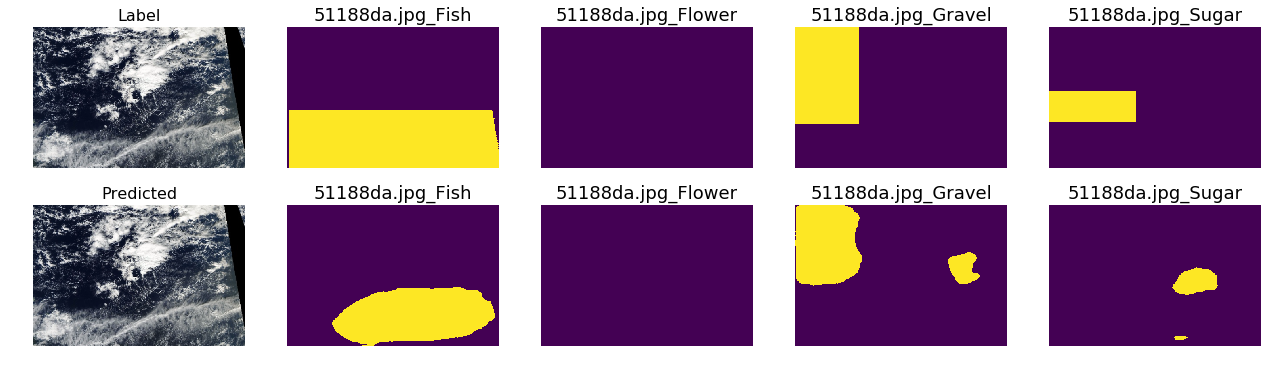

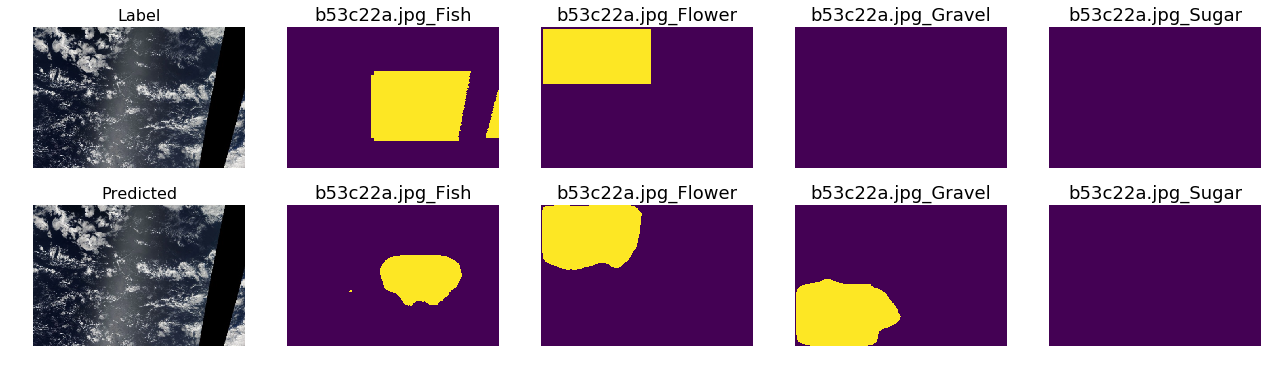

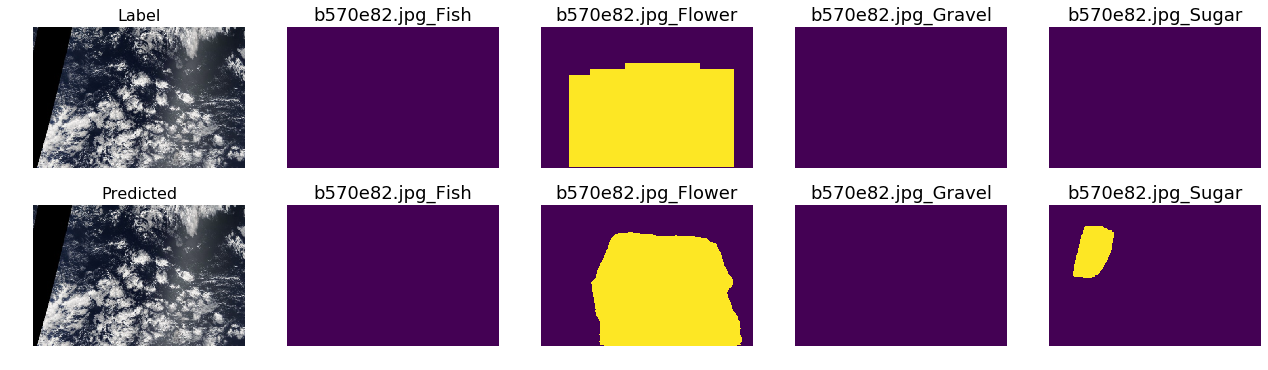

In [10]:
images_to_inspect = np.random.choice(X_val['image'].unique(), 3, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].round().astype(int)
    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[...,class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    ###
    inspect_set_temp.append(image_df)


inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process

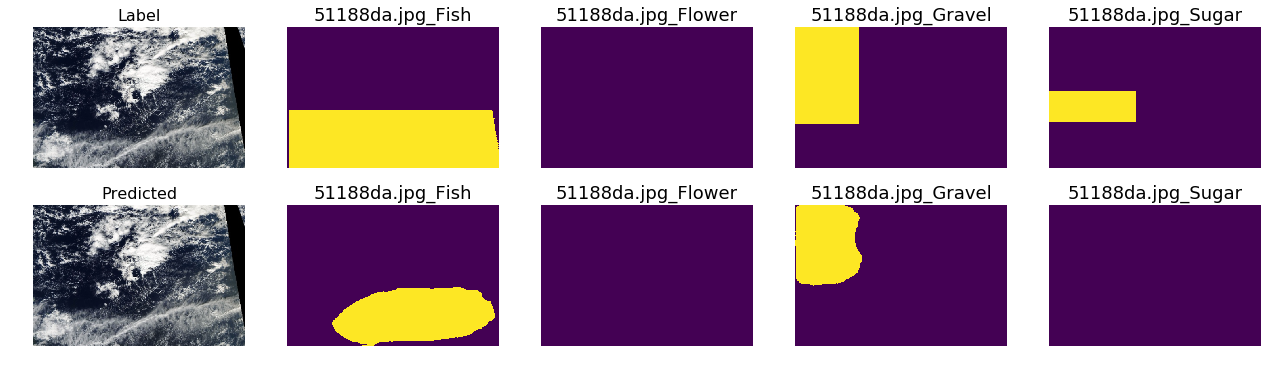

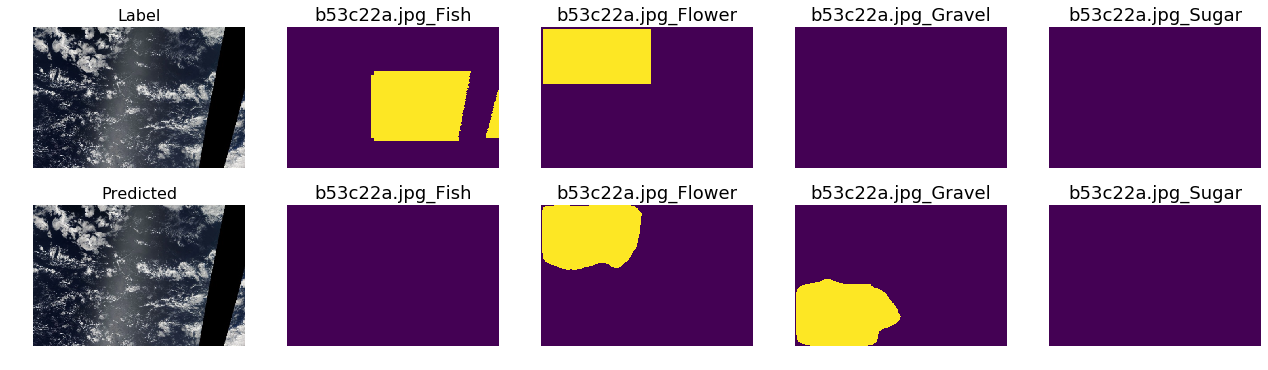

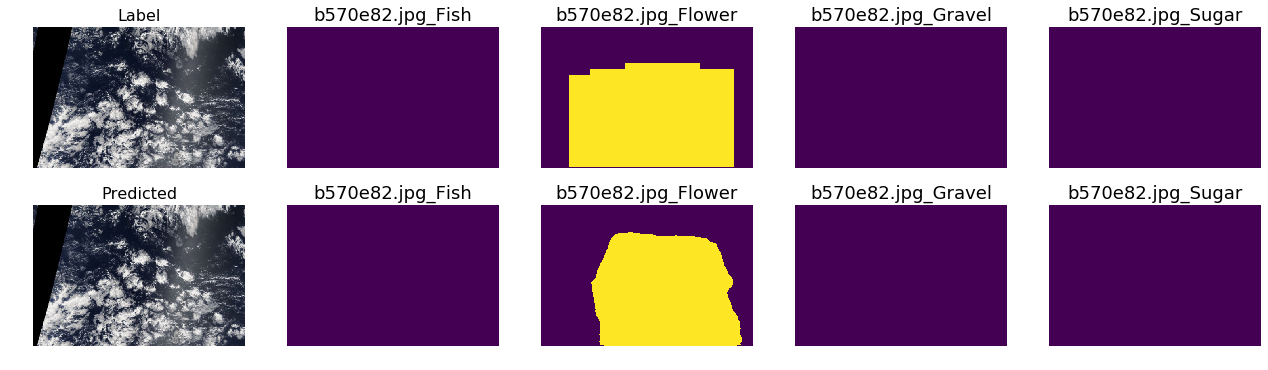

In [11]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')

# Apply segmentation model to test set

In [12]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

X_test = pd.concat(test_df)

# Using TTA Wrapper

In [13]:
segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, h_shift=(-10, 10), v_shift=(-10, 10), merge='mean')

## Inspecting some of the validation set predictions

### Without post-process and TTA

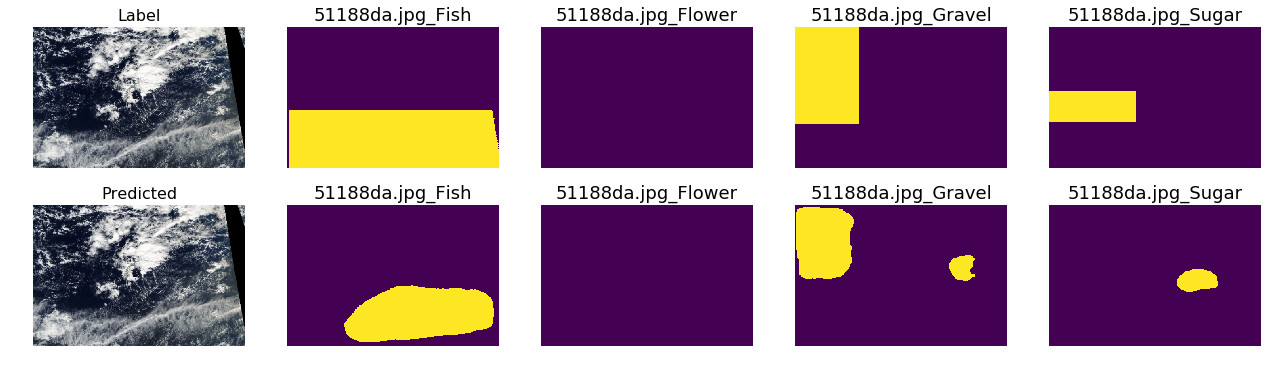

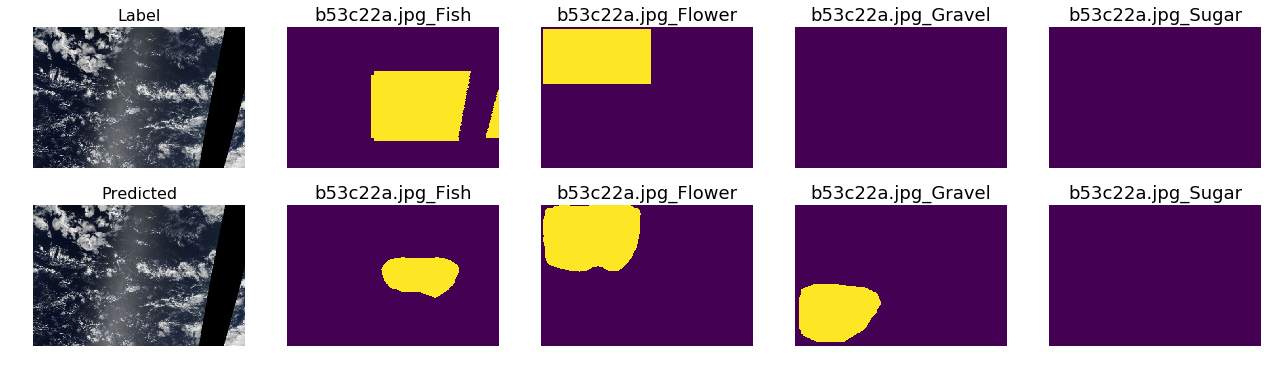

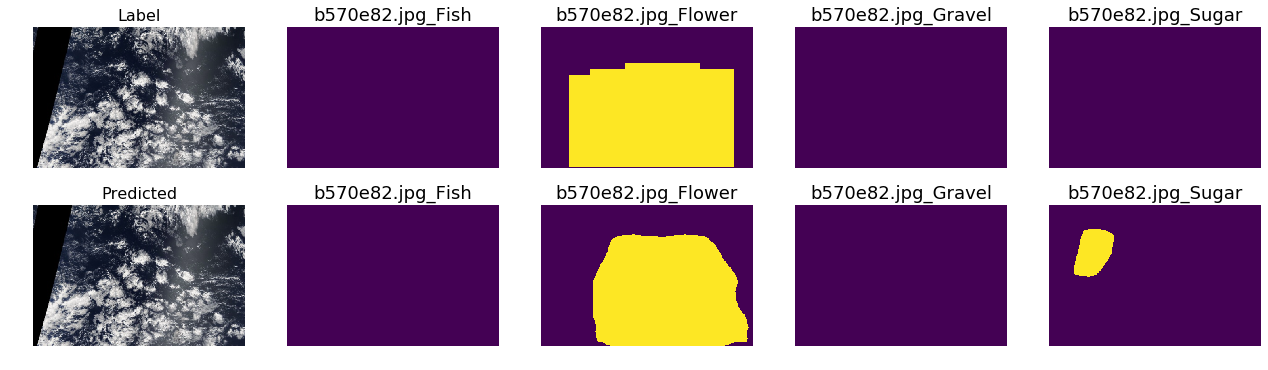

In [14]:
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(HEIGHT, WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model_tta.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].round().astype(int)
    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[...,class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    ###
    inspect_set_temp.append(image_df)


inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process and TTA

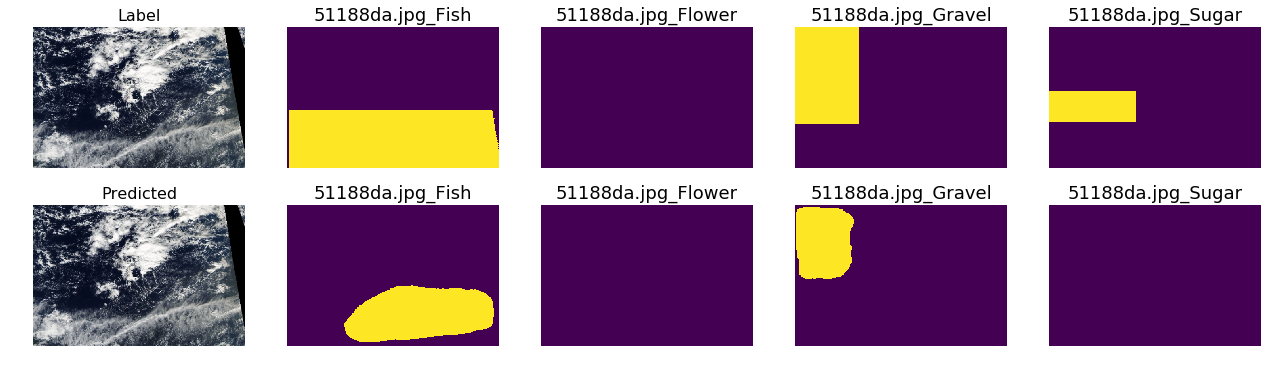

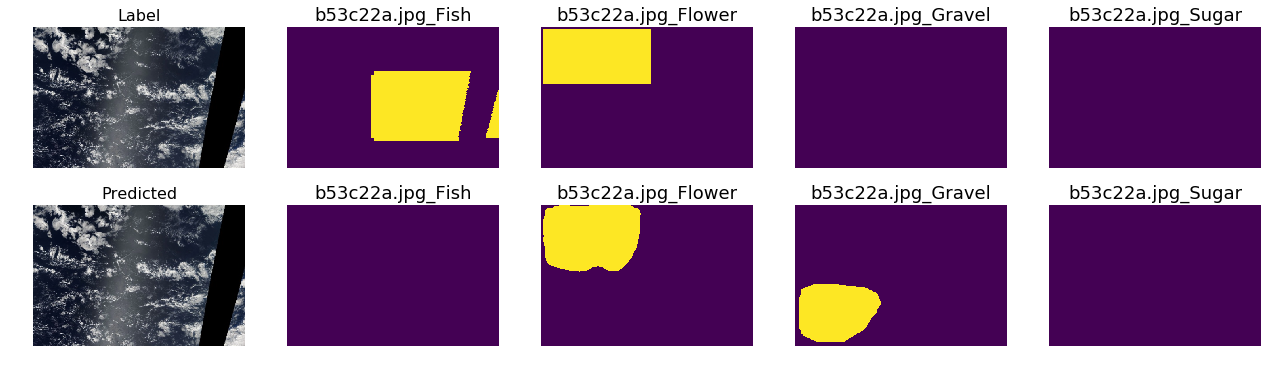

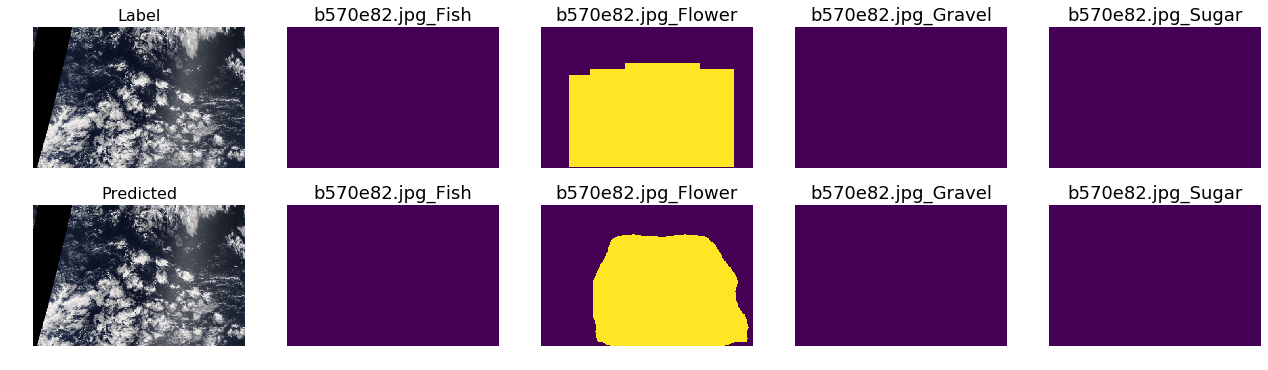

In [15]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')

# Apply segmentation model to test set (TTA)

In [16]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model_tta.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels_tta'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_tta'] = pred_rles_post
        ###
        
        test_df.append(image_df)

X_test_tta = pd.concat(test_df)

## Inspecting some of the test set predictions

### Without post-process

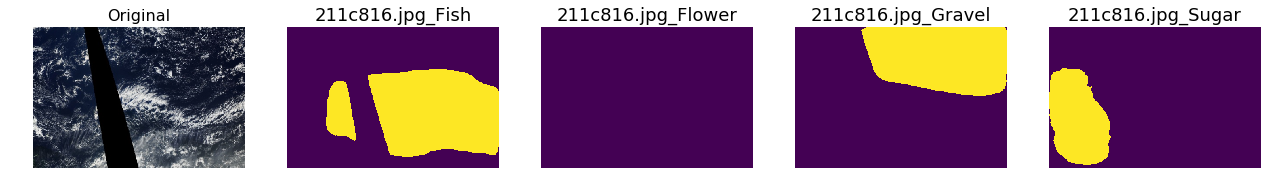

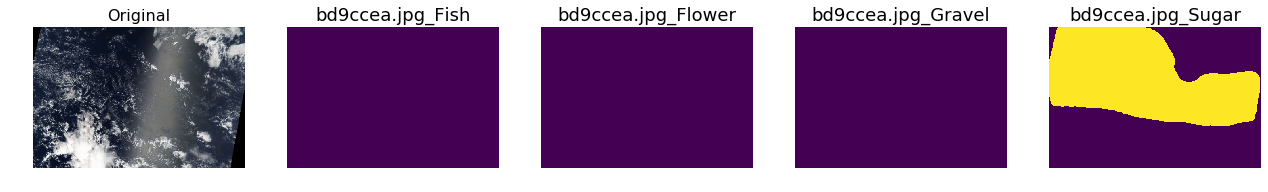

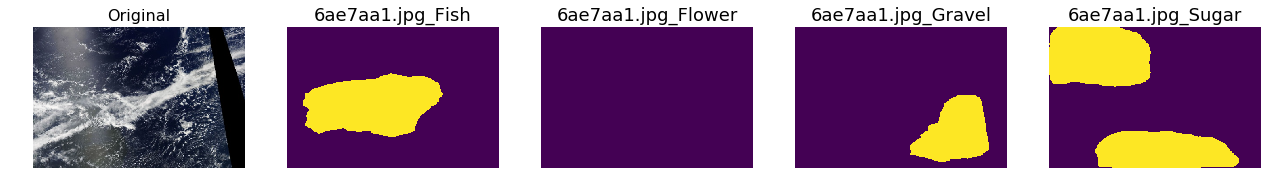

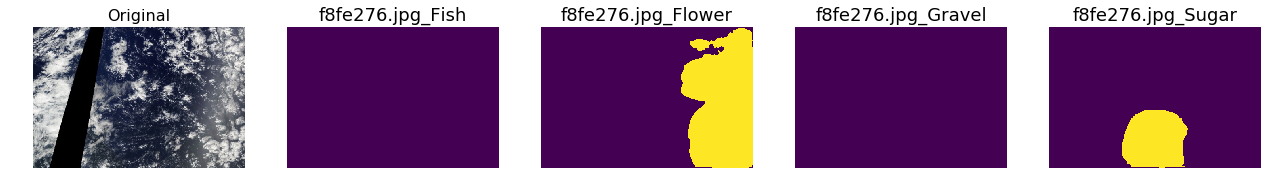

In [17]:
images_to_inspect_test =  np.random.choice(X_test['image'].unique(), 4, replace=False)
inspect_predictions(X_test, images_to_inspect_test, test_images_path)

### With post-process

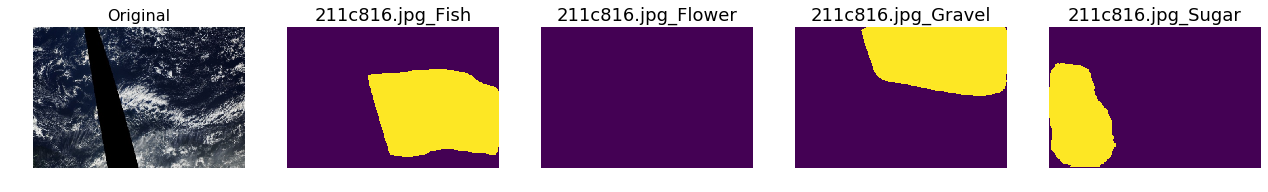

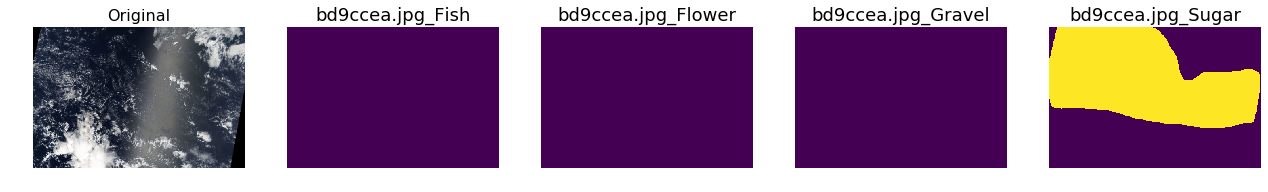

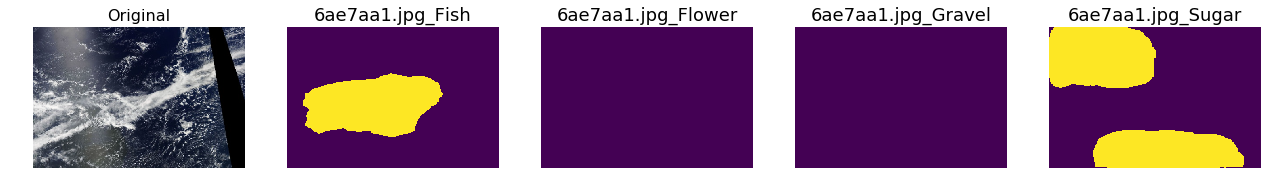

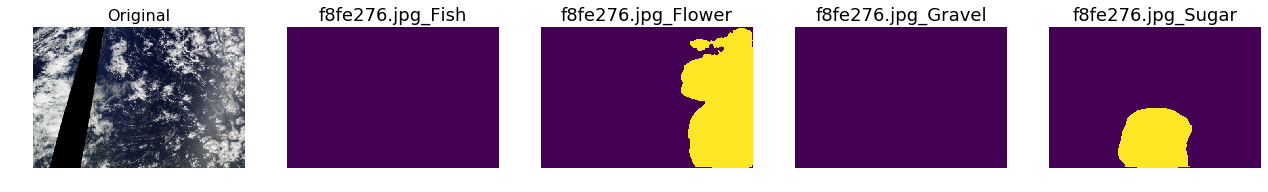

In [18]:
inspect_predictions(X_test, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### Without post-process and TTA

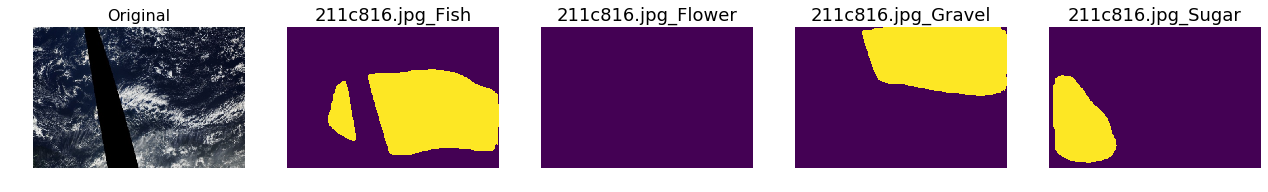

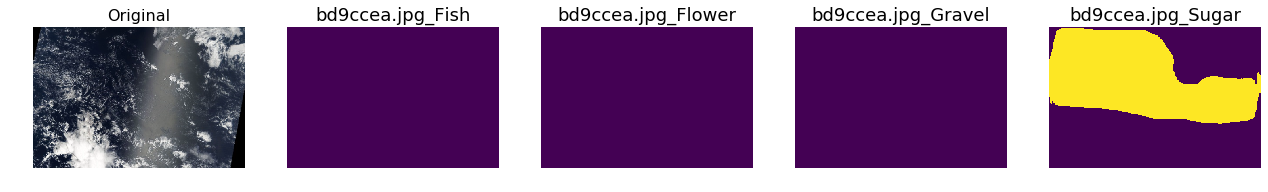

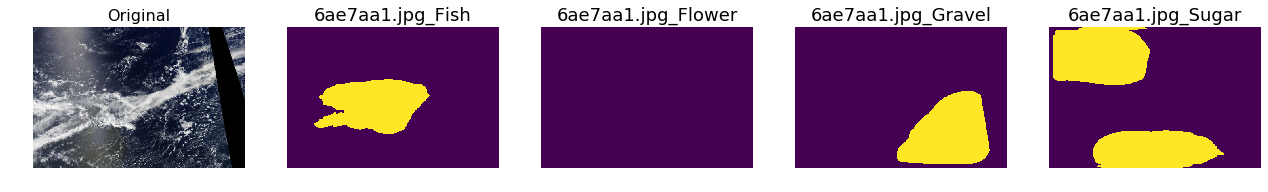

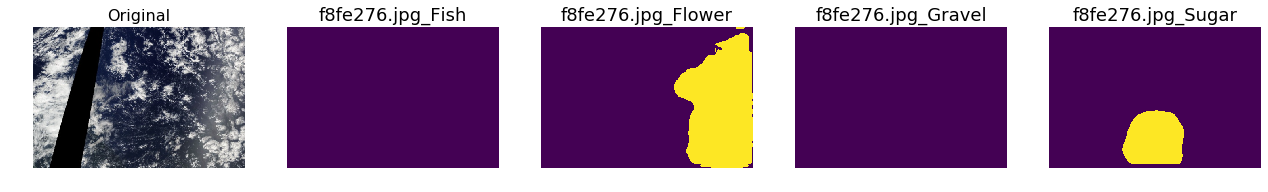

In [19]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

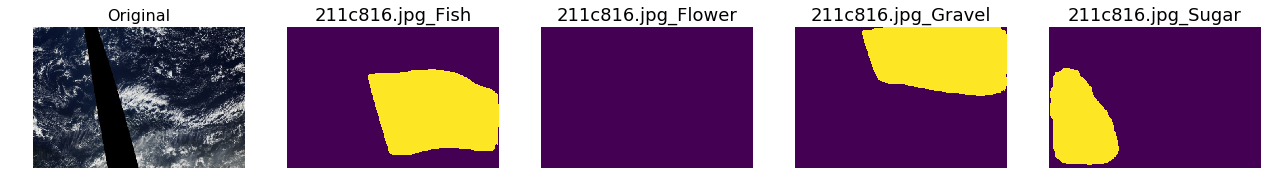

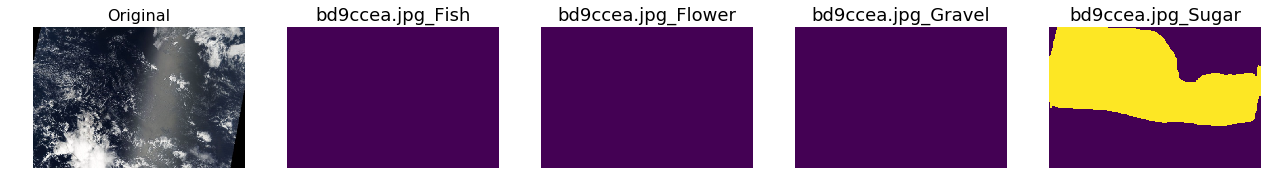

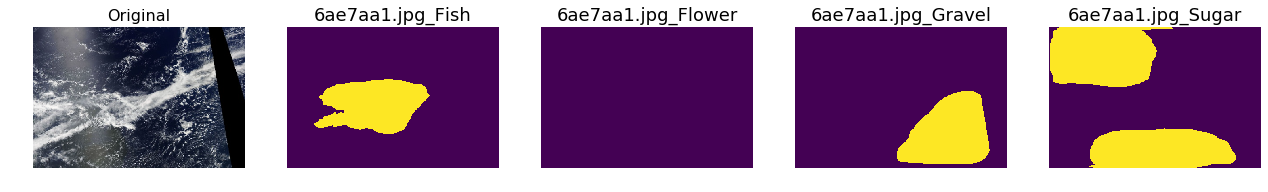

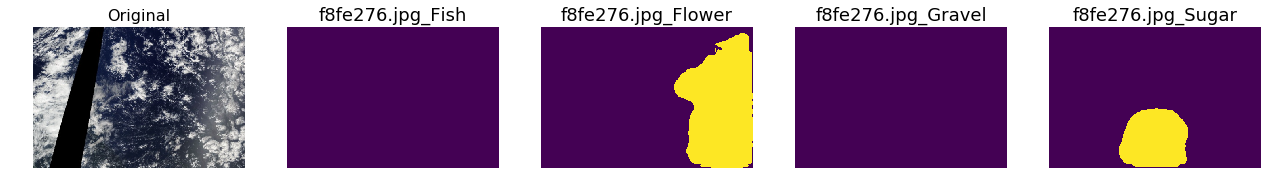

In [20]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### Regular submission

In [21]:
submission_df = X_test[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  15 318 365 318 710 331 1055 342 1403 345 1753 ...
3   002f507.jpg_Sugar  124084 9 124432 14 124780 17 125123 25 125471 ...
4    0035ae9.jpg_Fish  79603 1 79951 3 80301 4 90457 5 90806 10 91156...

### Submission with post processing

In [22]:
submission_df_post = X_test[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  15 318 365 318 710 331 1055 342 1403 345 1753 ...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish  90457 5 90806 10 91156 13 91506 15 91854 19 92...

### Submission with post processing and TTA

In [23]:
submission_df_post_class = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df_post_class.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post_class.to_csv('submission_post_tta.csv', index=False)
display(submission_df_post_class.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  2 307 352 307 702 333 1051 338 1395 2 1401 339...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish